## Value function iteration with and without labor supply

This notebook solves the income fluctuation problem both with and without labor choice using full discretization of the state space and value function iteration, with the option of using Howard's improvement step. The utility function used in this notebook is

$$u(c_t, l_t) = \frac{c_t^{1-\gamma}}{1-\gamma} - \phi \frac{l_t^{1+v}}{1+v}$$

but the methods in this lecture are compatible with general (non-separable) utility functions. Moreover, they are compatible with time constraints, if any are present. We begin with the case where labor is supplied inelastically, and then highlight the features of the algorithm that change when labor is supplied elastically.

### Step 1

Define the household tuple that holds our parameters. The function `setunevengrids` shows how to construct grids that are more dense in regions where one expects more curvature in policy functions. In this case, `setunevengrids` makes the discretization denser for low levels of assets.

In [126]:
include("rowenhorst_tauchen.jl") # include discretization functions (make sure it is in your working directory)

using Parameters, Plots, LinearAlgebra, Interpolations, BenchmarkTools

Household = @with_kw (apoints = 500, #asset grid
    amax = 70,  # asset max
    beta = 0.98, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 1, # elasticity of substitution
    bc = 0, # borrowing constraint (must be weakly negative)
    rho = 0.966,  # autocorr of income process
    num_states = 7, # number of states for income process
    sd = 0.13, # stand. dev. of deviation process
    mean = 0, # mean of income process
    uncond_sd = 0.13/sqrt(1-rho^2), # unconditional sd
    transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1], # transition matrix
    ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2], # grid for income process
    Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1], # asset grid (for uneven grids just set to "setunevengrids")
    Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2], # income grid (for uneven grids just set to "setunevengrids")
    phi = 0.8, # disutility factor
    frisch = 0.5) # frisch elasticity for labor supply 


function setgrids(bc, apoints, amax, num_states, ygrid)
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

# these grids are more dense on the lower portion of the asset grid where the policy functions have more curvature

function setunevengrids(bc, apoints, amax, num_states, ygrid)
    unevengrid = range(log(1/(-bc + 1)), length = apoints, stop = -log(amax + 1))
    unevengrid = exp.(-unevengrid) .- 1
    Amat = [i for i in unevengrid, j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end
    
hh = Household()

(apoints = 500, amax = 70, beta = 0.98, alpha = 0.11, deprec = 0.025, gamma = 1, bc = 0, rho = 0.966, num_states = 7, sd = 0.13, mean = 0, uncond_sd = 0.5028195291614176, transition_matrix = [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955], ygrid = [0.25738376293233367, 0.38804396244888767, 0.5850334732755494, 0.8820241982193845, 1.3297814941917474, 2.0048416198384222, 3.022594266947119], Amat = [0.0 0.0 … 0.0 0.0; 0.1402805611222445 0.1402805611222445 … 0.1402805611222445 0.1402805611222445; … ; 69.85971943887776 69.85971943887776 … 69.85971943887776 69.85971943887776; 70.0 70.0 … 70.0 70.0], Ymat = [0.25738376293233367 0.38804396244888767 … 2.0048416198384222 3.022594266947119; 0.2573837

### Step 2

We define the functions that are needed for the VFI algorithm. Let $A$ and $Y$ be the cardinality of the asset space and the income space, respectively. Then, `utility_matrix` creates an $A \times A \times Y$ matrix that holds the agent's instantaneous utility for all possible asset choices. For example, if the agent chooses future assets $a' = 2$ when he currently has $a = 1$ and income level $y=3$, this will be stored in the index $(1,2,3)$ of the output.

`bellman` completes a single value function iteration, and has an optional keyword for the number of Howard improving steps. `iterate_bellman` iterates on the value function until convergence. The iteration takes approximately seven seconds with the howard improvement step implemented, and seventy seconds without.

In [128]:
function u(c, gamma)
    if gamma == 1
        return log.(c)
    else
        return @. c^(1-gamma)/(1-gamma) 
    end
end

function c(k,knext,w,y,r,deprec)
    return @. (1+r)*k + w*y - knext
end

function utility_matrix(hh; w = 1, r = 0.01)
   @unpack apoints, deprec, gamma, num_states, Amat, ygrid =  hh
    
    consumption_matrix = zeros(apoints, apoints, num_states)
    utility_matrix = similar(consumption_matrix)
    
    for (k_ind, k) in enumerate(Amat[:,1])
        for (y_ind, y) in enumerate(ygrid)
            consumption_matrix[k_ind,:,y_ind] = c(k, Amat[:,1], w, y, r, deprec)
        end
    end
    
    mask = consumption_matrix.<0
    consumption_matrix[mask] .= 0 # debugging for log, otherwise throws error for negative numbers
    utility_matrix = u(consumption_matrix, gamma)
    utility_matrix[mask] .= -Inf
    
    return utility_matrix
end

function bellman(hh; utility_matrix, v, howard = 100)
    @unpack apoints, deprec, gamma, num_states, Amat, ygrid, beta, transition_matrix =  hh

    vnext = similar(v)
    policyfun = similar(v)

    for kind = 1:apoints
        for yind = 1:num_states

            max, maxind = findmax(utility_matrix[kind,:,yind] + beta.*(v[:,:]*transition_matrix[yind,:]))

            vnext[kind,yind] = max
            policyfun[kind, yind] = maxind
        end
    end
    
    # howard improvement step
    
    util_howard = similar(v)
    
    for yind = 1:num_states
        for kind = 1:apoints
            util_howard[kind, yind] = utility_matrix[kind, Int(policyfun[kind, yind]), yind]
        end
    end
    
    v = copy(vnext)
    
    for i = 1:howard
        for y = 1:num_states
           vnext[:,y] = util_howard[:,y] .+ beta.*v[Int.(policyfun[:,y]),:]*transition_matrix[y,:]
        end
        if norm(vnext .- v, Inf) < 1e-6
            return vnext, policyfun
        else
            v = copy(vnext)
        end
    end

    return vnext, policyfun
end

function iterate_bellman(hh; v, tol = 1e-6, maxiter = 100)
    util = utility_matrix(hh)
    
    iter = 0
    for i = 1:maxiter
        vnext, _ = bellman(hh; utility_matrix = util, v = v)
        if norm(vnext - v, Inf) < tol 
            println("bellman iteration successful!")
            println("iterations = $iter")
            return bellman(hh; utility_matrix = util, v = vnext)
        else
            v = vnext
            iter = iter +1
        end
    end
    
    error("no policy function convergence!")
end

@time v, policyfun = iterate_bellman(hh, v = zeros(hh.apoints,hh.num_states))


bellman iteration successful!
iterations = 21
  6.766639 seconds (2.40 M allocations: 4.511 GiB, 16.68% gc time)


([-29.285447838377298 -21.568068695025094 … 9.82639084200561 18.284652361001374; -28.846886402963925 -21.256824932591886 … 9.916294332577671 18.35557819364458; … ; 24.938336323402627 26.88399122333922 … 38.871596880659126 43.36959602038009; 24.995010701929008 26.938322697758665 … 38.91350851676144 43.407651871696714], [1.0 1.0 … 4.0 8.0; 1.0 1.0 … 5.0 9.0; … ; 488.0 488.0 … 494.0 499.0; 489.0 489.0 … 495.0 500.0])

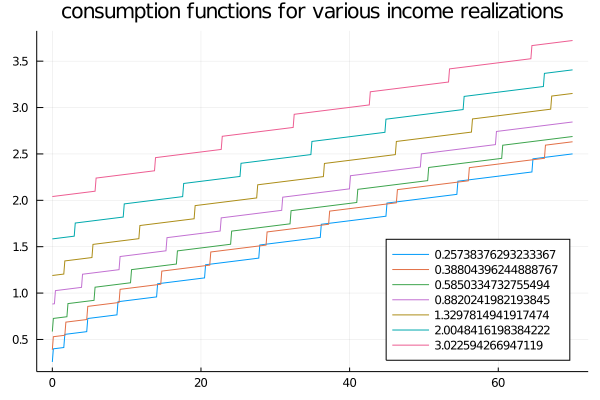

In [129]:
@unpack Amat, num_states, ygrid = hh

r = 0.01; w = 1;

cpolicy = similar(Amat)

for i = 1:num_states
    cpolicy[:,i] = (1+r).*Amat[:,1] .+ w.*ygrid[i] .- Amat[Int.(policyfun[:,i])]
end


p = plot()
for i = 1:num_states
    plot!(p, Amat[:,1],cpolicy[:,i], label = ygrid[i], legend = :bottomright)
end
plot(p, title = "consumption functions for various income realizations")



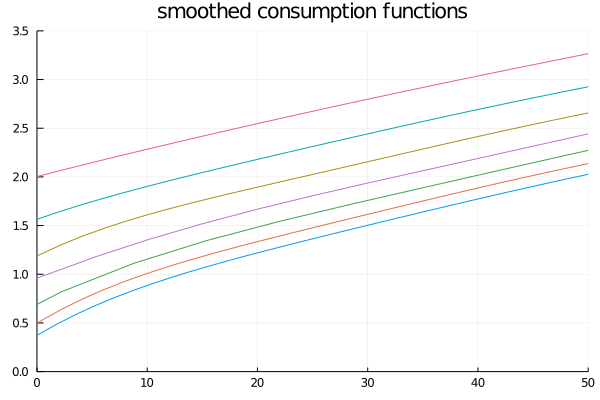

In [130]:
using Polynomials

p = plot()
for i = 1:num_states
    plot!(Polynomials.fit(Amat[:,1], cpolicy[:,i], 5), legend = false)
end

plot(p, title = "smoothed consumption functions", xlims = (0,50), ylims = (0,3.5))



### Step 3 (incorporating labor)

We now change the function `utility_matrix` to include endogenous labor supply choice. One (extremely inefficient) implementation would be to discretize the labor policy and include it as an additional dimension in the utility matrix. However, this does not take advantage of the the fact that labor choice is a ***static*** decision. In other words, ***once we know the future asset choice, we can solve the labor choice period by period***. This means that we only need to use a numerical solver *once*, where we maximize instantaneous utility for every value of the state space. Because this is a convex problem, it behaves nicely in the numerical implementation. The overhead of maximizing $A \times Y = 3500$ functions is about ten seconds, which is fine since we only need to do this once. Of course, this method works whenever we have static choices (and is not just limited to labor supply).

In [89]:
using Optim

function u(c, labor, gamma, phi, frisch)
    if gamma == 1
        return log.(c) - phi*(((labor)^(1+frisch))/(1+frisch))
    else
        return @. c^(1-gamma)/(1-gamma) - phi*(((labor)^(1+frisch))/(1+frisch))
    end
end

function c(k,knext,w,y,r,deprec,labor)
    return @. (1+r)*k + w*y*labor - knext
end

function utility_matrix_labor(hh; w, r)
    @unpack deprec, gamma, phi, frisch, Amat, apoints, num_states, ygrid = hh

    consumption_matrix = zeros(apoints, apoints, num_states)
    utility_matrix = similar(consumption_matrix)
    labor_matrix = similar(consumption_matrix)

    consumption(labor, k, knext, y) = max(c(k, knext, w, y, r, deprec, labor),0)
    totalutility(labor) = -u(consumption(labor, k, knext, y), labor, gamma, phi, frisch)
    
    
    for (k_ind, k) in enumerate(Amat[:,1])
        for (knext_ind, knext) in enumerate(Amat[:,1]) 
            for (y_ind, y) in enumerate(ygrid)
                res = optimize(labor -> -u(consumption(labor, k, knext, y), labor, gamma, phi, frisch), 0.0, 1.5)
                utility_matrix[k_ind, knext_ind, y_ind] = -res.minimum
                labor_matrix[k_ind, knext_ind, y_ind] = res.minimizer
            end
        end
    end

    return utility_matrix, labor_matrix
    
end

utility_matrix_labor(hh, w = 1, r = 0.01);


In [133]:
function iterate_bellman_labor(hh; v, tol = 1e-6, maxiter = 1000, w = 0.6, r = 0.01)
    util, labor_matrix = utility_matrix_labor(hh, w = w, r = r)
    
    iter = 0
    for i = 1:maxiter
        vnext, _ = bellman(hh; utility_matrix = util, v = v)
        if norm(vnext - v, Inf) < tol 
            println("bellman iteration successful!")
            println("iterations = $iter")
            v, policyfun = bellman(hh; utility_matrix = util, v = vnext)
            return v, policyfun, labor_matrix
        else
            v = vnext
            iter = iter +1
        end
    end
    
    error("no policy function convergence!")
end

# need smaller wage rate - otherwise becomes numerically unstable

v, policyfun, labor_matrix = iterate_bellman_labor(hh, v = zeros(hh.apoints,hh.num_states));

bellman iteration successful!
iterations = 23


In [134]:
labor_policy = similar(policyfun)

for j = 1:num_states
    for i = 1:length(policyfun[:,1])
        labor_policy[i,j] = labor_matrix[i,Int.(policyfun[i,j]),j]
    end
end

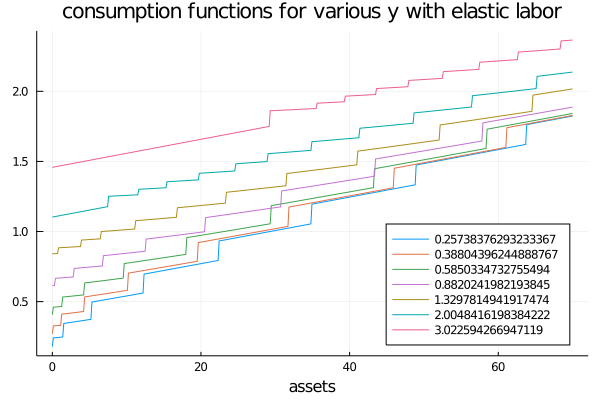

In [135]:
w = 0.6

for i = 1:num_states
    cpolicy[:,i] = (1+r).*Amat[:,1] .+ w.*ygrid[i].*labor_policy[:,i] .- Amat[Int.(policyfun[:,i])]
end


p = plot()
for i = 1:num_states
    plot!(p, Amat[:,1],cpolicy[:,i], label = ygrid[i], legend = :bottomright)
end

plot(p, title = "consumption functions for various y with elastic labor", xlabel = "assets")

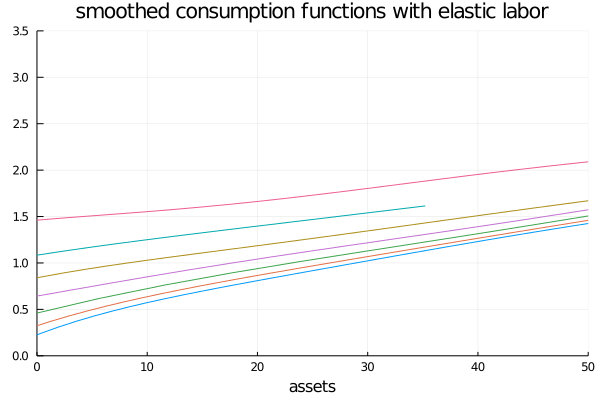

In [136]:
# last one with high wage rate did not converge, so not plotted

p = plot()
for i = 1:num_states
    plot!(Polynomials.fit(Amat[:,1], cpolicy[:,i], 5), legend = false)
end

plot(p, title = "smoothed consumption functions with elastic labor", xlims = (0,50), ylims = (0,3.5), xlabel = "assets")

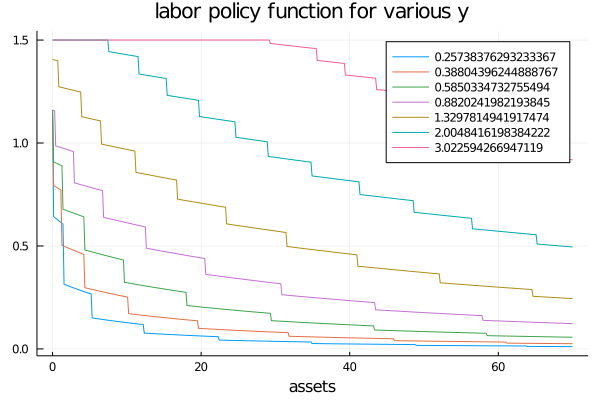

In [137]:
@unpack phi, frisch, gamma, num_states, ygrid = hh

w = 0.3

# laborpolicy = similar(cpolicy)

# for i = 1:num_states
#     laborpolicy[:,i] = (((cpolicy[:,i]).^(-gamma).*w.*ygrid[i])./phi).^(1/frisch)
# end

p = plot()
for i = 1:num_states
    plot!(p, Amat[:,1],labor_policy[:,i], label = ygrid[i], legend = :bottomright)
end

plot(p, legend = :topright, title = "labor policy function for various y", xlabel = "assets")